## Predictive rain prediction model
First predict rain probability, then predict how much it would likely rain.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as stm
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.regression.quantile_regression import QuantReg

In [2]:
combined_with_binary = pd.read_hdf("combined_with_binary.hdf5", "binary")
num_pos =  (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 0).sum(axis=1).rename("num_pos")
num_high_pos = (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 20).sum(axis=1).rename("num_high_pos")
num_very_pos = (combined_with_binary[[f"E{i+1}" for i in range(50)]] > 100).sum(axis=1).rename("num_very_pos")
combined_with_perc = combined_with_binary.join(num_pos).join(num_high_pos).join(num_very_pos)
combined_with_perc

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,median_pred_D-NE,median_pred_D-E,median_pred_D-SE,median_pred_D-S,median_pred_D-SW,median_pred_D-W,median_pred_D-NW,num_pos,num_high_pos,num_very_pos
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,0
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,42,0,0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,0.0,22.0,0.0,0.0,0.0,0.0,0.0,50,29,0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,0.0,0.0,0.0,0.0,29.0,0.0,0.0,50,39,0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0.0,0.0,0.0,0.0,31.5,0.0,0.0,50,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2021-04-27,240,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,0,0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,50,25,0


In [3]:
combined_with_perc.columns

Index(['det_run', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
       'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20',
       'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30',
       'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40',
       'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50',
       'E51', 'mean_pred', 'median_pred', 'min_pred', 'max_pred', 'pred_std',
       'pred_skew', 'pred_kurt', 'mode_pred', 'mode2_pred', 'mean_det_pred',
       'RH-fix', 'R', 'is-260', 'is-310', 'is-240', 'median_pred_is-240',
       'median_pred_is-260', 'median_pred_is-310', 'DD', 'FH', 'T', 'P', 'N',
       'U', 'D-N', 'D-NE', 'D-E', 'D-SE', 'D-S', 'D-SW', 'D-W', 'D-NW',
       'median_pred_D-N', 'median_pred_D-NE', 'median_pred_D-E',
       'median_pred_D-SE', 'median_pred_D-S', 'median_pred_D-SW',
       'median_pred_D-W', 'median_pred_D-NW', 'num_pos', 'num_high_pos',
       'num_very_pos'],
      

In [4]:
def perc_corr_pred(model, data, true, perc = 0.5):
    pred_value = np.zeros(len(data))
    is_corr = np.zeros(len(data))
    true_value = np.array(true)
    
    pred_value = model.predict(data)[1] > perc

    return np.equal(pred_value, true_value).mean()

In [33]:
logit_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr="logit").fit(method="bfgs")
display(perc_corr_pred(logit_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(logit_model.summary())
display(logit_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.355100
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


0.8594536304816679

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1975.8
Model:                   OrderedModel   AIC:                             3956.
Method:            Maximum Likelihood   BIC:                             3969.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:33:45                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.1155      0.003     37.113      0.000       0.109       0.122
0.0/1.0        3.8857      0.138     28.189      0.000       3.615       4.156
==============================================================================
"""

0.47267781327798664

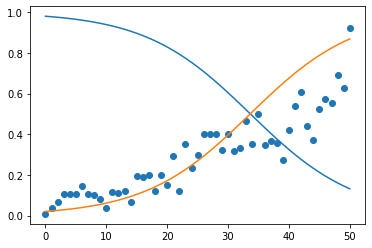

In [6]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, logit_model.predict(x))
plt.show()

In [7]:
gompit_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.gumbel_r).fit(method="bfgs")
display(perc_corr_pred(gompit_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(gompit_model.summary())
display(gompit_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.347179
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16


0.8632278936017254

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1931.7
Model:                   OrderedModel   AIC:                             3867.
Method:            Maximum Likelihood   BIC:                             3881.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:26:06                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0881      0.003     34.611      0.000       0.083       0.093
0.0/1.0        3.6260      0.121     29.923      0.000       3.389       3.864
==============================================================================
"""

0.4844410988106389

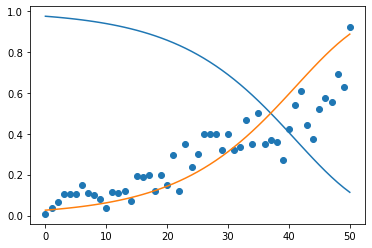

In [8]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, gompit_model.predict(x))
plt.show()

In [9]:
expon_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.expon).fit(method="bfgs")
display(perc_corr_pred(expon_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(expon_model.summary())
display(expon_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.337952
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


0.8684399712437095

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1880.4
Model:                   OrderedModel   AIC:                             3765.
Method:            Maximum Likelihood   BIC:                             3778.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:26:06                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0645      0.002     30.829      0.000       0.060       0.069
0.0/1.0        3.3215      0.104     32.004      0.000       3.118       3.525
==============================================================================
"""

0.4981438763007129

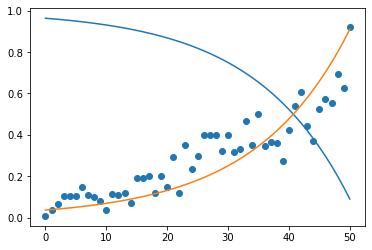

In [10]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, expon_model.predict(x))
plt.show()

In [11]:
wald_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos"]], distr=sts.wald).fit(method="bfgs")
display(perc_corr_pred(wald_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(wald_model.summary())
display(wald_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.338369
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 21


0.8662832494608196

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1882.7
Model:                   OrderedModel   AIC:                             3769.
Method:            Maximum Likelihood   BIC:                             3783.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:26:08                                         
No. Observations:                5564                                         
Df Residuals:                    5562                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_pos        0.0567      0.002     26.233      0.000       0.052       0.061
0.0/1.0        3.0634      0.107     28.587      0.000       2.853       3.273
==============================================================================
"""

0.4975240120996641

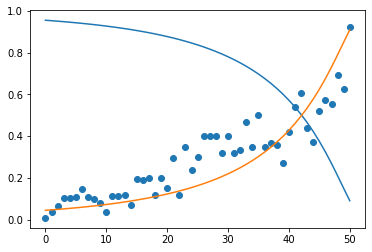

In [12]:
_data = combined_with_perc.groupby("num_pos").mean()["R"]
plt.scatter(_data.index, _data.values)
x = np.arange(0, 51)
plt.plot(x, wald_model.predict(x))
plt.show()

In [42]:
logistic_model = OrderedModel(combined_with_binary["R"], combined_with_perc[["num_pos", "num_high_pos"]], distr="probit").fit(method="bfgs")
# display(perc_corr_pred(wald_model, combined_with_perc[["num_pos"]], combined_with_binary["R"]))
display(logistic_model.summary())
display(logistic_model.prsquared)

Optimization terminated successfully.
         Current function value: 0.299298
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      R   Log-Likelihood:                -1665.3
Model:                   OrderedModel   AIC:                             3337.
Method:            Maximum Likelihood   BIC:                             3356.
Date:                Sun, 19 Jun 2022                                         
Time:                        16:36:45                                         
No. Observations:                5564                                         
Df Residuals:                    5561                                         
Df Model:                           3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
num_pos          0.0481      0.002     31.778      0.000       0.045       0.051
num_high_pos     0.0444      0.002     17.781      0.000       0.040       0.049
0.0/1.0          1.8892      0.059     31.826      0.000       1.773       2.005
================================================================================
"""

0.5555435019207211

## Positive rain
Assume that it rains, how much does it rain?

In [70]:
only_raining = combined_with_perc[combined_with_perc["R"] == 1]
only_raining

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,median_pred_D-NE,median_pred_D-E,median_pred_D-SE,median_pred_D-S,median_pred_D-SW,median_pred_D-W,median_pred_D-NW,num_pos,num_high_pos,num_very_pos
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-02,260,1.0,1.0,5.0,2.0,3.0,3.0,1.0,1.0,2.0,1.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,42,0,0
2016-04-03,260,34.0,20.0,8.0,22.0,19.0,26.0,19.0,28.0,12.0,25.0,...,0.0,22.0,0.0,0.0,0.0,0.0,0.0,50,29,0
2016-04-04,260,17.0,44.0,54.0,29.0,29.0,44.0,54.0,9.0,61.0,22.0,...,0.0,0.0,0.0,0.0,29.0,0.0,0.0,50,39,0
2016-04-05,260,30.0,18.0,8.0,24.0,58.0,36.0,41.0,30.0,43.0,25.0,...,0.0,0.0,0.0,0.0,31.5,0.0,0.0,50,34,0
2016-04-06,260,27.0,36.0,28.0,46.0,25.0,35.0,25.0,37.0,28.0,28.0,...,0.0,0.0,0.0,0.0,31.5,0.0,0.0,50,49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-15,240,6.0,5.0,4.0,3.0,2.0,7.0,2.0,4.0,10.0,7.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,50,0,0
2021-04-19,240,27.0,17.0,49.0,7.0,23.0,16.0,13.0,58.0,75.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16.5,50,19,0
2021-04-28,240,41.0,27.0,10.0,38.0,29.0,5.0,31.0,14.0,32.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,50,25,0


In [71]:
stm.OLS(only_raining["RH-fix"], stm.add_constant(only_raining[["median_pred", "is-240", "is-260", "median_pred_is-240", "median_pred_is-260", "median_pred_is-310", "min_pred", "max_pred", "mean_pred", "mode_pred", "T", "P", "N", "U", "FH", "D-N", "D-NE", "D-E", "D-SE", "D-S", "D-SW", "D-W", "D-NW", "median_pred_D-N", "median_pred_D-NE", "median_pred_D-E", "median_pred_D-SE", "median_pred_D-S", "median_pred_D-SW", "median_pred_D-W", "median_pred_D-NW"]])).fit(cov_type="HC0").summary()

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 31, but rank is 29
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RH-fix   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     166.0
Date:                Sun, 19 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:44:20   Log-Likelihood:                -16715.
No. Observations:                3333   AIC:                         3.349e+04
Df Residuals:                    3304   BIC:                         3.367e+04
Df Model:                          28                                         
Covariance Type:                  HC0                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -152.3603     53.453     -2.850      0.004    -257.127     -47.594
median_pred            0.8249      0.486      1.699      0.089      -0.127       1.777
is-240                 0.6302      3.086      0.204      0.838      -5.418       6.678
is-260                -0.4230      2.372     -0.178      0.858      -5.072       4.226
median_pred_is-240     0.2458      0.174      1.414      0.157      -0.095       0.587
median_pred_is-260     0.3240      0.180      1.799      0.072      -0.029       0.677
median_pred_is-310     0.2551      0.162      1.575      0.115      -0.062       0.573
min_pred               0.3639      0.206      1.765      0.078      -0.040       0.768
max_pred               0.0841      0.060      1.396      0.163      -0.034       0.202
mean_pred             -0.2936      0.748     -0.392      0.695      -1.760       1.173
mode_pred             -0.1130      0.165     -0.685      0.493      -0.436       0.210
T                      0.0164      0.013      1.262      0.207      -0.009       0.042
P                      0.0169      0.006      2.941      0.003       0.006       0.028
N                     -0.2498      0.241     -1.035      0.301      -0.723       0.223
U                      0.0022      0.066      0.034      0.973      -0.127       0.132
FH                    -0.0656      0.028     -2.382      0.017      -0.120      -0.012
D-N                  -19.1654      6.847     -2.799      0.005     -32.584      -5.746
D-NE                 -21.2967      7.303     -2.916      0.004     -35.610      -6.983
D-E                  -15.2686      7.033     -2.171      0.030     -29.053      -1.484
D-SE                 -21.1653      7.278     -2.908      0.004     -35.430      -6.900
D-S                  -21.1852      7.459     -2.840      0.005     -35.804      -6.566
D-SW                 -12.6556      6.772     -1.869      0.062     -25.929       0.618
D-W                  -19.2316      7.376     -2.607      0.009     -33.689      -4.774
D-NW                 -22.3920      7.228     -3.098      0.002     -36.559      -8.225
median_pred_D-N       -0.0750      0.089     -0.845      0.398      -0.249       0.099
median_pred_D-NE       0.1997      0.230      0.869      0.385      -0.251       0.650
median_pred_D-E       -0.0797      0.136     -0.584      0.559      -0.347       0.188
median_pred_D-SE       0.2651      0.156      1.696      0.090      -0.041       0.571
median_pred_D-S        0.2075      0.119      1.743      0.081      -0.026       0.441
median_pred_D-SW      -0.0464      0.089     -0.521      0.602      -0.221       0.128
median_pred_D-W        0.1460      0.111      1.310      0.190      -0.072       0.364
median_pred_D-NW       0.2077      0.106      1.966      0.049       0.001       0.415
======================================

In [75]:
stm.OLS(only_raining["RH-fix"], stm.add_constant(only_raining[["median_pred", "P"]])).fit(cov_type="HC0").summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.547     
Dependent Variable: RH-fix           AIC:                33537.1463
Date:               2022-06-19 17:44 BIC:                33555.4812
No. Observations:   3333             Log-Likelihood:     -16766.   
Df Model:           2                F-statistic:        329.4     
Df Residuals:       3330             Prob (F-statistic): 2.89e-131 
R-squared:          0.548            Scale:              1371.1    
-------------------------------------------------------------------
                Coef.   Std.Err.    z    P>|z|    [0.025    0.975] 
-------------------------------------------------------------------
const         -215.5412  54.6494 -3.9441 0.0001 -322.6520 -108.4304
median_pred      1.1189   0.0459 24.3967 0.0000    1.0290    1.2088
P                0.0210   0.0053  3.9436 0.0001    0.0106    0.0315
-------------------------------------------------------------------
Omnibus:            2703.751      Durbin-Watson:         1.912     
Prob(Omnibus):      0.000         Jarque-Bera (JB):      133147.780
Skew:               3.486         Prob(JB):              0.000     
Kurtosis:           33.169        Condition No.:         970532    
===================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""